In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

import csv

def plot_weights(model):
    for layer in model.layers:
        W = layer.get_weights()[0]

        for i in range(W.shape[2]):
            for j in range(W.shape[3]):
                print(W[:,:,i,j])
                plt.subplot(W.shape[2], W.shape[3], 1+j+i*W.shape[3])
                plt.imshow((W[:,:,i,j]+1)/2, cmap="gray")
        plt.show()

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def show_board(board):
    for row in board:
        for piece in row:
            if piece[2]:
                letter = 'K'
            elif piece[3]:
                letter = 'Q'
            elif piece[4]:
                letter = 'R'
            elif piece[5]:
                letter = 'N'
            elif piece[6]:
                letter = 'B'
            elif piece[7]:
                letter = 'P'
            else:
                letter = '.'

            if piece[1]:
                letter = letter.lower()

            print(letter, end='')
        print()

def show_moves(moves):
    for row in moves:
        for move in row:
            move = 'X' if move[0] else '.'
            print(move, end='')
        print()

print("Done importing.")

Done importing.


In [2]:
FILTERS = {
    'neutral': np.zeros((3,3,1)),
}
for j in range(3):
    for i in range(3):
        filter = np.zeros((3,3,1))
        filter[i][j] = 1
        FILTERS['pos'+str(i+j*3)] = filter
        
        
# def make_weight(filters):
    

# WEIGHTS = {
#     'whitebishop': make_weight({'white':'pos4','bishop':'pos4'})
    
#     [np.array(
#             #   Wh   Bl    K    Q    R    N    B    P   mv   ep
#             [[[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 2],[ 0],[ 0],[ 0],[ 0],[ 0],[ 2],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]]]
#         ),
#         np.array([-3])],
#     'pos0_whitebishop': [np.array(
#             #   Wh   Bl    K    Q    R    N    B    P   mv   ep   wb
#             [[[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 1]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]],
#              [[[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]],
#               [[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0],[ 0]]]]
#         ),
#         np.array([0])],
# }

# WEIGHTS['whitebishop'] = 

TRAINING_SIZE = 19000
TOTAL_SIZE = 31000

piece_to_id = {
	'K':[1,0,0,0,0,0],
	'Q':[0,1,0,0,0,0],
	'R':[0,0,1,0,0,0],
	'N':[0,0,0,1,0,0],
	'B':[0,0,0,0,1,0],
	'P':[0,0,0,0,0,1],
}

LAYERS = [
    'white',
    'black',
    'king',
    'queen',
    'rook',
    'knight',
    'bishop',
    'pawn',
    'has_moved',
    'enpassant',
]

from collections import defaultdict
cache = defaultdict(str)

print("Ok.")

Ok.


In [4]:
X = []
Y = []
i = 0
for line in csv.reader(open('moves.csv'), delimiter='|'):
    i+= 1
    if i > TOTAL_SIZE:
        break

    player = 1 if int(line[0]) == 1 else 0
    if not player:
        continue

    found_bishop=False

    colors = [[1,0]]*16 + [[0,1]]*16
    pieces = [piece_to_id[char] for char in line[2].split(',')]
    has_moved = [([1] if n!='0' else [0]) for n in line[3].split(',')]
    enpassant = [[0]]*32
    if line[4]:
        enpassant[int(line[4])-1] = [1]

    squares = []
    for row in chunks(line[1].split(','), 8):
        rank = []
        for id in row:
            if not id:
                square = [0,0] + [0]*6 + [0] + [0]
            else:
                id = int(id)-1
                if pieces[id] == [0,0,0,0,1,0]:
                    found_bishop = True
                square = colors[id] + pieces[id] + has_moved[id] + enpassant[id]
            rank.append(square)
        squares.append(rank)

    if not found_bishop:
        continue

    X.append(squares)

    destinations = []
    for line in chunks(line[5].split(','), 8):
        destinations.append([(1 if n!='0' else 0) for n in line])
    Y.append(destinations)

X = np.array(X).astype('float32')
Y = np.array(Y)
Y = np.expand_dims(Y, 3)

print(len(X))

22766


In [57]:
# model = Sequential()
# model.add(Conv2D(1, (3, 3), padding='same', activation='relu', input_shape=(8,8,1)))

# model.compile(
#     loss=keras.losses.mean_squared_error,
#     metrics=['accuracy', keras.metrics.TruePositives()]
# )

# best_accuracy = 0
# best_TPR = 0
# best_filter = ''
# best_property = None
# while 'neutral_white' not in LAYERS:
#     for key, filter in FILTERS.items():
#         model.layers[0].set_weights([
#                 np.expand_dims(np.array(filter), 3),
#                 np.array([0])
#         ])
#         # plot_weights(model)

#         for i, X_slice in enumerate(np.split(X, X.shape[3], 3)):
#             if key+'_'+LAYERS[i] in LAYERS:
#                 print("Already considering", key+'_'+LAYERS[i])
#                 continue
#             if key+'_'+LAYERS[i] not in cache:
#                 cache[key+'_'+LAYERS[i]] = model.evaluate(X_slice, Y, verbose=0)
#                 print(key, LAYERS[i], 'accuracy:', cache[key+'_'+LAYERS[i]][1])
#             score = cache[key+'_'+LAYERS[i]]
# #             print(key, LAYERS[i], 'TPR:', score[2])
#             if best_accuracy + 0.00000001 < score[1]:
#                 best_accuracy = score[1]
#                 best_property = i
#                 best_filter = key
#             if key=='neutral':
#                 break

#     if best_filter+'_'+LAYERS[best_property] in LAYERS:
#         print("Could not improve result with basic filters.")
#         break
                
#     print(best_filter, 'got an accuracy of', best_accuracy, 'on', LAYERS[best_property])

#     model.layers[0].set_weights([
#         np.expand_dims(np.array(FILTERS[best_filter]), 3),
#         np.array([0])
#     ])

#     Y_prob = (model.predict(np.split(X, X.shape[3], 3)[best_property]) > .5).astype('int')

#     for i, y_prob in enumerate(Y_prob):
#         if not (y_prob == Y_test[i]).all():
#             show_board(X_test[i])
#             print()
#             show_moves(y_prob)
#             print()
#             show_moves(Y_test[i])
#             print('-----')
#             break
            
#     X = np.concatenate((X, Y_prob), 3)
#     LAYERS.append(best_filter+'_'+LAYERS[best_property])
#     print("Appended", best_filter+'_'+LAYERS[best_property], 'to LAYERS')

Already considering pos0_bishop
Already considering pos0_pos0_bishop
Already considering pos8_pos0_pos0_bishop
pos4 got an accuracy of 0.85379034 on pos8_pos0_pos0_bishop
R.K.....
....b.r.
..P.PP.N
.P......
...NkpPp
....p.R.
...B....
...n....

........
...X..X.
........
........
........
........
........
........

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
Appended pos4_pos8_pos0_pos0_bishop to LAYERS
Already considering pos0_bishop
Already considering pos0_pos0_bishop
pos0 pos4_pos8_pos0_pos0_bishop accuracy: 0.85370934
pos1 pos4_pos8_pos0_pos0_bishop accuracy: 0.8340048
pos2 pos4_pos8_pos0_pos0_bishop accuracy: 0.82670224
pos3 pos4_pos8_pos0_pos0_bishop accuracy: 0.8333075
Already considering pos4_pos8_pos0_pos0_bishop
pos4 pos4_pos8_pos0_pos0_bishop accuracy: 0.85379034
pos5 pos4_pos8_pos0_pos0_bishop accuracy: 0.8307379
pos6 pos4_pos8_pos0_pos0_bishop accuracy: 0.8265485
pos7 pos4_pos8_pos0_pos0_bishop accuracy: 0.8306253
Already considering pos8

In [7]:
model = Sequential()
# model.add(Conv2D(1, (1, 1), padding='same', activation='relu', input_shape=(8,8,X.shape[3])))
# model.add(Conv2D(1, (3, 3), padding='same', activation='relu'))

model.add(Conv2D(1, (3, 3), padding='same', activation='relu', input_shape=(8,8,X.shape[3])))

model.compile(
    loss=keras.losses.mean_squared_error,
    metrics=['accuracy', keras.metrics.TruePositives()]
)

best_accuracy = 0
best_TPR = 0
best_filter = ''
best_property = None
while 'neutral_white' not in LAYERS:
    for key, filter in FILTERS.items():
#         filter = np.zeros((1,1,X.shape[3]))
#         filter[0] = 1.5
#         filter[6] = 1.5

#         model.layers[1].set_weights([
#                 np.expand_dims(np.array(filter), 3),
#                 np.array([0])
#         ])
        model.layers[0].set_weights([
                np.expand_dims(np.array(filter), 3),
                np.array([0])
        ])
        # plot_weights(model)

        for i, X_slice in enumerate(np.split(X, X.shape[3], 3)):
            if key+'_'+LAYERS[i] in LAYERS:
                print("Already considering", key+'_'+LAYERS[i])
                continue
            if key+'_'+LAYERS[i] not in cache:
                cache[key+'_'+LAYERS[i]] = model.evaluate(X, Y, verbose=0)
                print(key, LAYERS[i], 'accuracy:', cache[key+'_'+LAYERS[i]][1])
            score = cache[key+'_'+LAYERS[i]]
#             print(key, LAYERS[i], 'TPR:', score[2])
            if best_accuracy + 0.00000001 < score[1]:
                best_accuracy = score[1]
                best_property = i
                best_filter = key
            if key=='neutral':
                break

    if best_filter+'_'+LAYERS[best_property] in LAYERS:
        print("Could not improve result with basic filters.")
        break
                
    print(best_filter, 'got an accuracy of', best_accuracy, 'on', LAYERS[best_property])

    model.layers[0].set_weights([
        np.expand_dims(np.array(FILTERS[best_filter]), 3),
        np.array([0])
    ])

    Y_prob = (model.predict(np.split(X, X.shape[3], 3)[best_property]) > .5).astype('int')

    for i, y_prob in enumerate(Y_prob):
        if not (y_prob == Y_test[i]).all():
            show_board(X_test[i])
            print()
            show_moves(y_prob)
            print()
            show_moves(Y_test[i])
            print('-----')
            break
            
    X = np.concatenate((X, Y_prob), 3)
    LAYERS.append(best_filter+'_'+LAYERS[best_property])
    print("Appended", best_filter+'_'+LAYERS[best_property], 'to LAYERS')

ValueError: Layer weight shape (3, 3, 10, 1) not compatible with provided weight shape (3, 3, 1, 1)

Train on 19000 samples, validate on 3766 samples
Epoch 1/500
17152/19000 [==========================>...] - ETA: 0s - loss: 0.1426 - accuracy: 0.8388
Epoch 00001: val_loss improved from inf to 0.15192, saving model to best_model.h5
19000/19000 [==============================] - 1s 61us/sample - loss: 0.1430 - accuracy: 0.8383 - val_loss: 0.1519 - val_accuracy: 0.8274
Epoch 2/500
17408/19000 [==========================>...] - ETA: 0s - loss: 0.1433 - accuracy: 0.8378
Epoch 00002: val_loss improved from 0.15192 to 0.15176, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1428 - accuracy: 0.8385 - val_loss: 0.1518 - val_accuracy: 0.8275
Epoch 3/500
16768/19000 [=========================>....] - ETA: 0s - loss: 0.1429 - accuracy: 0.8383
Epoch 00003: val_loss improved from 0.15176 to 0.15158, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1427 - accuracy: 0.8386 - val_loss: 0.1516 - v

17024/19000 [=========================>....] - ETA: 0s - loss: 0.1373 - accuracy: 0.8417
Epoch 00026: val_loss improved from 0.14649 to 0.14623, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1375 - accuracy: 0.8415 - val_loss: 0.1462 - val_accuracy: 0.8303
Epoch 27/500
18816/19000 [============================>.] - ETA: 0s - loss: 0.1372 - accuracy: 0.8417
Epoch 00027: val_loss improved from 0.14623 to 0.14596, saving model to best_model.h5
19000/19000 [==============================] - 0s 24us/sample - loss: 0.1373 - accuracy: 0.8416 - val_loss: 0.1460 - val_accuracy: 0.8304
Epoch 28/500
16896/19000 [=========================>....] - ETA: 0s - loss: 0.1366 - accuracy: 0.8423
Epoch 00028: val_loss improved from 0.14596 to 0.14569, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1370 - accuracy: 0.8417 - val_loss: 0.1457 - val_accuracy: 0.8305
Epoch 29/500
16640/19000 [=========

16896/19000 [=========================>....] - ETA: 0s - loss: 0.1256 - accuracy: 0.8483
Epoch 00076: val_loss improved from 0.13363 to 0.13340, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1254 - accuracy: 0.8485 - val_loss: 0.1334 - val_accuracy: 0.8373
Epoch 77/500
17152/19000 [==========================>...] - ETA: 0s - loss: 0.1252 - accuracy: 0.8488
Epoch 00077: val_loss improved from 0.13340 to 0.13317, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1252 - accuracy: 0.8487 - val_loss: 0.1332 - val_accuracy: 0.8375
Epoch 78/500
17408/19000 [==========================>...] - ETA: 0s - loss: 0.1251 - accuracy: 0.8488
Epoch 00078: val_loss improved from 0.13317 to 0.13295, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1250 - accuracy: 0.8489 - val_loss: 0.1329 - val_accuracy: 0.8376
Epoch 79/500
16640/19000 [=========

16384/19000 [========================>.....] - ETA: 0s - loss: 0.1160 - accuracy: 0.8596
Epoch 00126: val_loss improved from 0.12378 to 0.12362, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1161 - accuracy: 0.8594 - val_loss: 0.1236 - val_accuracy: 0.8484
Epoch 127/500
18048/19000 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.8595
Epoch 00127: val_loss improved from 0.12362 to 0.12346, saving model to best_model.h5
19000/19000 [==============================] - 0s 21us/sample - loss: 0.1159 - accuracy: 0.8596 - val_loss: 0.1235 - val_accuracy: 0.8485
Epoch 128/500
16640/19000 [=========================>....] - ETA: 0s - loss: 0.1156 - accuracy: 0.8601
Epoch 00128: val_loss improved from 0.12346 to 0.12330, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1158 - accuracy: 0.8599 - val_loss: 0.1233 - val_accuracy: 0.8489
Epoch 129/500
18432/19000 [======

16000/19000 [========================>.....] - ETA: 0s - loss: 0.1098 - accuracy: 0.8663
Epoch 00176: val_loss improved from 0.11706 to 0.11695, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.1096 - accuracy: 0.8666 - val_loss: 0.1169 - val_accuracy: 0.8557
Epoch 177/500
17280/19000 [==========================>...] - ETA: 0s - loss: 0.1098 - accuracy: 0.8664
Epoch 00177: val_loss improved from 0.11695 to 0.11684, saving model to best_model.h5
19000/19000 [==============================] - 0s 21us/sample - loss: 0.1095 - accuracy: 0.8667 - val_loss: 0.1168 - val_accuracy: 0.8559
Epoch 178/500
16896/19000 [=========================>....] - ETA: 0s - loss: 0.1095 - accuracy: 0.8666
Epoch 00178: val_loss improved from 0.11684 to 0.11673, saving model to best_model.h5
19000/19000 [==============================] - 0s 22us/sample - loss: 0.1094 - accuracy: 0.8668 - val_loss: 0.1167 - val_accuracy: 0.8559
Epoch 179/500
18304/19000 [======

16768/19000 [=========================>....] - ETA: 0s - loss: 0.1050 - accuracy: 0.8708
Epoch 00226: val_loss improved from 0.11212 to 0.11203, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.1049 - accuracy: 0.8709 - val_loss: 0.1120 - val_accuracy: 0.8596
Epoch 227/500
18944/19000 [============================>.] - ETA: 0s - loss: 0.1048 - accuracy: 0.8710
Epoch 00227: val_loss improved from 0.11203 to 0.11194, saving model to best_model.h5
19000/19000 [==============================] - 0s 23us/sample - loss: 0.1048 - accuracy: 0.8710 - val_loss: 0.1119 - val_accuracy: 0.8597
Epoch 228/500
17152/19000 [==========================>...] - ETA: 0s - loss: 0.1049 - accuracy: 0.8708
Epoch 00228: val_loss improved from 0.11194 to 0.11185, saving model to best_model.h5
19000/19000 [==============================] - 0s 21us/sample - loss: 0.1047 - accuracy: 0.8711 - val_loss: 0.1119 - val_accuracy: 0.8598
Epoch 229/500
18688/19000 [======

16640/19000 [=========================>....] - ETA: 0s - loss: 0.1011 - accuracy: 0.8750
Epoch 00276: val_loss improved from 0.10810 to 0.10803, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.1011 - accuracy: 0.8751 - val_loss: 0.1080 - val_accuracy: 0.8641
Epoch 277/500
17920/19000 [===========================>..] - ETA: 0s - loss: 0.1010 - accuracy: 0.8753
Epoch 00277: val_loss improved from 0.10803 to 0.10795, saving model to best_model.h5
19000/19000 [==============================] - 1s 29us/sample - loss: 0.1010 - accuracy: 0.8752 - val_loss: 0.1080 - val_accuracy: 0.8642
Epoch 278/500
16896/19000 [=========================>....] - ETA: 0s - loss: 0.1010 - accuracy: 0.8752
Epoch 00278: val_loss improved from 0.10795 to 0.10788, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.1009 - accuracy: 0.8753 - val_loss: 0.1079 - val_accuracy: 0.8643
Epoch 279/500
18048/19000 [======

16640/19000 [=========================>....] - ETA: 0s - loss: 0.0978 - accuracy: 0.8799
Epoch 00326: val_loss improved from 0.10467 to 0.10460, saving model to best_model.h5
19000/19000 [==============================] - 0s 26us/sample - loss: 0.0978 - accuracy: 0.8798 - val_loss: 0.1046 - val_accuracy: 0.8698
Epoch 327/500
17920/19000 [===========================>..] - ETA: 0s - loss: 0.0978 - accuracy: 0.8800
Epoch 00327: val_loss improved from 0.10460 to 0.10454, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0978 - accuracy: 0.8800 - val_loss: 0.1045 - val_accuracy: 0.8699
Epoch 328/500
17024/19000 [=========================>....] - ETA: 0s - loss: 0.0976 - accuracy: 0.8803
Epoch 00328: val_loss improved from 0.10454 to 0.10448, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0977 - accuracy: 0.8801 - val_loss: 0.1045 - val_accuracy: 0.8700
Epoch 329/500
17408/19000 [======

18816/19000 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.8858
Epoch 00376: val_loss improved from 0.10170 to 0.10165, saving model to best_model.h5
19000/19000 [==============================] - 1s 37us/sample - loss: 0.0950 - accuracy: 0.8858 - val_loss: 0.1016 - val_accuracy: 0.8761
Epoch 377/500
18048/19000 [===========================>..] - ETA: 0s - loss: 0.0949 - accuracy: 0.8860
Epoch 00377: val_loss improved from 0.10165 to 0.10159, saving model to best_model.h5
19000/19000 [==============================] - 1s 32us/sample - loss: 0.0950 - accuracy: 0.8860 - val_loss: 0.1016 - val_accuracy: 0.8762
Epoch 378/500
18432/19000 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.8862
Epoch 00378: val_loss improved from 0.10159 to 0.10154, saving model to best_model.h5
19000/19000 [==============================] - 1s 31us/sample - loss: 0.0949 - accuracy: 0.8861 - val_loss: 0.1015 - val_accuracy: 0.8762
Epoch 379/500
18176/19000 [======

17408/19000 [==========================>...] - ETA: 0s - loss: 0.0925 - accuracy: 0.8908
Epoch 00426: val_loss improved from 0.09914 to 0.09910, saving model to best_model.h5
19000/19000 [==============================] - 0s 25us/sample - loss: 0.0926 - accuracy: 0.8908 - val_loss: 0.0991 - val_accuracy: 0.8818
Epoch 427/500
18176/19000 [===========================>..] - ETA: 0s - loss: 0.0926 - accuracy: 0.8908
Epoch 00427: val_loss improved from 0.09910 to 0.09905, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0925 - accuracy: 0.8909 - val_loss: 0.0990 - val_accuracy: 0.8819
Epoch 428/500
17408/19000 [==========================>...] - ETA: 0s - loss: 0.0927 - accuracy: 0.8907
Epoch 00428: val_loss improved from 0.09905 to 0.09900, saving model to best_model.h5
19000/19000 [==============================] - 1s 35us/sample - loss: 0.0925 - accuracy: 0.8909 - val_loss: 0.0990 - val_accuracy: 0.8820
Epoch 429/500
18688/19000 [======

16896/19000 [=========================>....] - ETA: 0s - loss: 0.0905 - accuracy: 0.8950
Epoch 00476: val_loss improved from 0.09690 to 0.09686, saving model to best_model.h5
19000/19000 [==============================] - 1s 30us/sample - loss: 0.0904 - accuracy: 0.8951 - val_loss: 0.0969 - val_accuracy: 0.8863
Epoch 477/500
16768/19000 [=========================>....] - ETA: 0s - loss: 0.0903 - accuracy: 0.8953
Epoch 00477: val_loss improved from 0.09686 to 0.09682, saving model to best_model.h5
19000/19000 [==============================] - 1s 27us/sample - loss: 0.0904 - accuracy: 0.8952 - val_loss: 0.0968 - val_accuracy: 0.8864
Epoch 478/500
17664/19000 [==========================>...] - ETA: 0s - loss: 0.0905 - accuracy: 0.8950
Epoch 00478: val_loss improved from 0.09682 to 0.09677, saving model to best_model.h5
19000/19000 [==============================] - 1s 34us/sample - loss: 0.0904 - accuracy: 0.8952 - val_loss: 0.0968 - val_accuracy: 0.8865
Epoch 479/500
18944/19000 [======

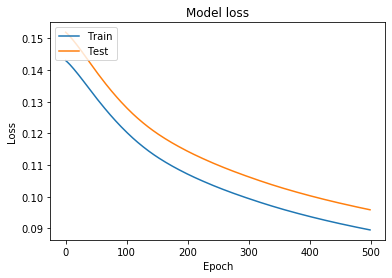

In [40]:
X_train = X[:TRAINING_SIZE]
Y_train = Y[:TRAINING_SIZE]
X_test  = X[TRAINING_SIZE:]
Y_test  = Y[TRAINING_SIZE:]

model = Sequential()
model.add(Conv2D(5, (3, 3), padding='same', activation='relu', input_shape=X[0].shape))
model.add(Conv2D(1, (3, 3), padding='same', activation='relu'))

model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    batch_size=128,
    epochs=500,
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=True,
    callbacks = [
        ModelCheckpoint(
            filepath='best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
        )]
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
Y_prob = (model.predict(X_test) > .5).astype('int')

for i, y_prob in enumerate(Y_prob):

	if not (y_prob == Y_test[i]).all():
		show_board(X_test[i])
		print()
		show_moves(y_prob)
		print()
		show_moves(Y_test[i])
		print('-----')

R.K.....
....b.r.
..P.PP.N
.P......
...NkpPp
....p.R.
...B....
...n....

........
........
.....X..
......X.
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
..K...r.
....b...
..P.PP.N
.P......
R..NkpPp
....p.R.
...B....
...n....

........
........
.....X..
......X.
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
........
.K..b...
..P.PPrN
.P......
R..NkpPp
....p.R.
...B....
...n....

........
........
...X.X..
......X.
.......X
..X.....
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
........
..K.b...
..P.PPrN
.P......
R..NkpPp
..n.p.R.
...B....
........

........
........
...X.X..
......X.
.......X
....X...
........
..X.X...

........
........
.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
-----
........
..K.....
..P.PPrN
.P......
Rb..kpPp
..n.p.R.
...BN...
........

........
........
........
..X.

.nrk..n.

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BR.
PP.K....
N.QP....
b.P.PP.P
.Npppp.p
.p.q..pr
p...b...
.nrk..n.

........
.X.XX.X.
.X..X..X
.....X..
........
..X.....
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BR.
PP.K....
N..P....
bQP.PP.P
.Npppp.p
.p....pr
p.q.b...
.nrk..n.

........
.X.X..X.
....X..X
.....X..
........
..X.....
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB..BR.
PP.K....
...P....
bQP.PP.P
pNpppp.p
.p....pr
..q.b...
.nrk..n.

........
.X.X..X.
..X.X..X
.....X..
........
..X.....
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB..BR.
PP.K....
N..P....
bQP.PP.P
p.pppp.p
.pq...pr
....b...
.nrk..n.

........
.X.X..X.
..X.X..X
.....X..
........
..X.....
........
........

........
.X.XX.X.
X..

..X.X...
.....X..
........
........
........
........

..X.X...
......X.
..X.XX..
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
R......B
P..B...b
...K....
...r.p..
...Pp...
........
........
...kr..R

..X.X...
........
....X...
.....X..
........
........
........
........

..X.X...
......X.
..X.XX..
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
R.....bB
P.KB....
........
...r.p..
...Pp...
........
........
...kr..R

..X.X...
........
..X.X...
.....X..
........
........
........
........

..X.X...
......X.
..X.XX..
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
..R...bB
P.KB....
........
...r.p..
...Pp...
........
..k.....
....r..R

..X.X...
........
..X.X...
.....X..
........
........
........
........

..X.X...
......X.
..X.XX..
.X..XX..
X..X..X.
..X....X
.X......
X.......
-----
..R...bB
P.KB....
........
...r.p..
...Pp...
........
........
.k..r.R.

..X.X...
........
..X.X...
.....X..
........
........
........
........

..X.X...
......X.
..X.XX..
.X..XX..
X..X..X.
..X.


........
X.X.....
...X....
........
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B....b.
K.......
....p...
........
P.......
.....k..
........
........

........
X.X.....
...X....
........
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B....b.
........
.K..p...
........
P.......
........
.....k..
........

........
X.X.....
...X....
....X...
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
.......b
....p...
K.......
P.......
........
.....k..
........

........
X.X.....
...X....
....X...
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
........
.......b
....p...
K...B...
P.......
........
........
.....k..

........
........
........
........
...X.X..
......X.
.......X
........

.X.....X
..X...X.
...X.X..
...

........
........
..X.....
........
X.X.....

.......X
......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
-----
........
........
........
........
..bB....
....K...
........
.......k

........
........
........
........
........
....X...
....XX..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
........
B.......
........
........
........
....K...
........
.....b.k

.X......
........
.X......
..X.....
...X....
........
........
........

.X......
........
.X......
..X.....
...X....
....X...
.....X..
......X.
-----
........
........
........
..B.....
........
....K...
........
.....bk.

........
........
.X.X....
........
.X.X....
....X...
.....X..
........

.....X..
X...X...
.X.X....
........
.X.X....
X...X...
.....X..
......X.
-----
........
........
b.......
........
...B....
....K...
........
......k.

........
........
........
..X.....
..X.....
..X.X...
.....X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X..

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBR.
PPPPPPP.
.....N.P
........
...p....
..p...p.
pp..pp.p
rnbqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBR.
PPPPPPP.
.......P
.......N
...p....
p.p...p.
.p..pp.p
rnbqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBR.
PPPPPP..
.......P
......PN
...p....
ppp...p.
....pp.p
rnbqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBR.
.PPPPP..
.......P
P.....PN
...p....
ppp.b.p.
....pp.p
rn.qkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X.

........
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NB.....
RPPP..Q.
.....K..
...pP..P
Rq..k.rB
....pp..
.....n.p
.n.r....

........
.X.X....
....X...
.....XX.
........
........
........
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NB.....
R.PP..Q.
.....K..
.P.pP..P
Rq..k..B
....pp..
.....nrp
.n.r....

........
.X.X....
....X...
......X.
........
........
........
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.NB.....
R.P...Q.
...P.K..
.P.pP..P
Rq..k..B
....pp.p
.....nr.
.n.r....

........
.X.X....
....X...
......X.
........
......X.
........
........

...X....
.X.XX...
X...XX..
.....XX.
......X.
......XX
.....X..
....X...
-----
.N......
R.P...Q.
...PBK..
.P.pP..P
Rq..k..B
n...pp.p
.....nr.
...r....

........
.....X..
.....X..
...X.XX.
......X.
........
........
........

..XX..X.
...XXX..
.....X..
...X.XX.
..X...X.
.X....XX
X....X..
....X...
-----
.N.....

........
........
........
........
........
........
.....X..

........
........
........
........
........
........
........
........
-----
.......R
......K.
N..P....
k..p...P
b......p
........
........
........

........
........
........
........
........
........
..X.....
...X....

........
........
........
........
........
........
........
........
-----
.......R
...b....
N..P.K..
k..p...P
.......p
........
........
........

........
........
........
.....X..
......X.
........
........
........

........
........
........
........
........
........
........
........
-----
..b....R
........
...P.K..
k..p...P
.N.....p
........
........
........

........
...X....
........
.....X..
........
........
........
........

........
........
........
........
........
........
........
........
-----
..b....R
........
...P.K..
.k.p...P
.......p
........
..N.....
........

........
...X....
........
.....X..
........
........
........
........

........
........
........
........
....

........
........
........
........
........
.....X..
......X.

........
........
........
........
........
........
........
........
-----
...R....
......b.
k.......
......K.
........
........
........
........

........
........
.....X..
........
........
........
........
........

........
........
........
........
........
........
........
........
-----
...R....
........
k.......
....bK..
........
........
........
........

........
........
........
........
........
......X.
.......X
........

........
........
........
........
........
........
........
........
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKB.R
PPPPPPPP
.....N..
........
........
.......p
ppppppp.
rnbqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X..

XX.X....
........
-----
NQ...R..
......PP
....B..K
p.Pq.P..
......p.
P..p.p..
.p...k..
r.B.....

........
...X.X..
........
...X.X..
......X.
........
...X....
........

..X...X.
...X.X..
.......X
...X.XX.
..X..XX.
XX..X..X
XX.X....
........
-----
N....R..
......PP
....B..K
p.Pq.P..
......p.
P..p.p..
.p.....Q
r.B..k..

........
...X.X..
........
...X.X..
......X.
........
...X....
........

..X...X.
...X.X..
.......X
...X.XX.
..X..XX.
XX..X..X
XX.X....
........
-----
N....R..
......PP
....B..K
p.Pq.P..
......p.
P..p.p..
.p.B...Q
.r...k..

........
...X.X..
........
...X.X..
......X.
....X...
........
..X.....

..X...X.
...X.X..
.......X
X..X.XX.
.XX..XX.
.XX.X..X
X.......
..X.X...
-----
N...R...
......PP
....B..K
p.Pq.P..
......p.
P..p.p..
.p.B...Q
r....k..

........
...X.X..
........
...X.X..
......X.
....X...
........
........

..X...X.
...X.X..
.......X
X..X.XX.
.XX..XX.
.XX.X..X
X.......
..X.X...
-----
N...R...
......PP
....B..K
p.Pq.P..
......p.
P..p.p..
.p.Bk...
r.......

.......

.pR....P
p...p...
..p.k.b.
.r....nr

........
......X.
........
......X.
........
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.P..
PPPP.b..
...P.p.q
.p....RP
p...p..b
..p.k...
.r....nr

........
......X.
........
......X.
.......X
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.P..
PPPP.b..
.p.P.p.q
.......P
p...p..b
..p.k...
.r....Rr

........
.X....X.
........
......X.
.......X
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.P..
.PPP.b..
Pp.P.p.q
.......P
p...p..b
..p.k...
...r..Rr

........
......X.
........
......X.
.......X
........
........
........

........
......X.
.....X..
....X...
...X....
..X.....
.X......
X.......
-----
RNn...QB
...K.PR.
.PPP.b..
Pp.P.p.q
.......P
p...p..b
..p.k..r
...r....

........
......X.
........
....X.X.
.......X
........
........
....

.....X.X
.X.X....
....XX.X
........
........
........
........
........

.....X.X
.X.X....
X...XX.X
....XX..
...X..X.
..X....X
.X......
X.......
-----
R.BK..N.
P..P.PB.
NP..P..R
....p.Pp
........
bPpp...n
p...bk.p
rn...q.r

.....X.X
.X.X....
....XX.X
.....X..
........
........
........
........

.....X.X
.X.X....
X...XX.X
....XX..
...X..X.
..X....X
.X......
X.......
-----
R.B...N.
P.KP.PB.
NP..P..R
....p.Pp
........
bPpp....
p...bk.p
rn...qnr

.....X.X
.X.X....
....XX.X
.....X..
........
........
........
........

.....X.X
.X.X....
X...XX.X
....XX..
...X..X.
..X....X
.X......
X.......
-----
.RB...N.
P.KP.PB.
NP..P..R
....p.Pp
........
bPpp....
p...b..p
rn..kqnr

.....X.X
...X....
....XX.X
.....X..
........
........
........
........

.....X.X
.X.X....
X...XX.X
....XX..
...X..X.
..X....X
.X......
X.......
-----
.RB...N.
P.KP.P..
NP..PB.R
....p.Pp
........
bPpp....
p..nb..p
r...kqnr

........
...X..X.
....X...
....XXX.
.......X
........
........
........

...X...X
.X.XX.X.
X...X...
....

....X...
.....X..
........
........

X...X...
.X.X....
.......X
.X.X..X.
X...XX..
X...XX..
.X.X..X.
.......X
-----
K..N....
...q....
..B...p.
PR...P.b
......R.
..pp....
r.......
..B..kr.

........
.X......
........
.X.X....
....X...
.....X..
........
........

X...X...
.X.X....
.......X
.X.X..X.
X...XX..
X...XX..
.X.X..X.
.......X
-----
K..N....
.Bq.....
......p.
PR...P.b
......R.
..pp....
r.......
..B..kr.

X.......
........
X.X.....
...X....
....X...
........
........
........

X.X.....
........
X.X....X
...X..X.
....XX..
X...XX..
.X.X..X.
.......X
-----
K..N....
.Bq.....
......p.
PR.....b
.....PR.
..pp....
......r.
..B..kr.

X.......
........
X.X.....
...X....
........
........
........
........

X.X.....
........
X.X....X
...X..X.
....XX..
X...XX..
.X.X..X.
.......X
-----
K..N....
.Bq.....
......p.
PR.....b
.....PR.
..pp....
.B.....r
.....kr.

X.......
........
X.X.....
...X....
....X...
..X.....
........
X.X.....

X.X....X
......X.
X.X..X..
...XX...
...XX...
X.X..X..
......X.
X.X.

..X.XX..
.....XX.
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
........
..K.....
.N..R.p.
..p.....
...B....
Rb.p..P.
........
.k......

........
........
........
....X...
........
..X.X...
.....X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
..K.....
........
.N..R.p.
..p.....
...B....
Rb.p..P.
........
..k.....

........
........
........
....X...
........
..X.X...
.....X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
..K.....
......p.
.N...R..
..p.....
...B....
Rb.p..P.
........
..k.....

........
........
........
....X...
........
..X.X...
.....X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
..K.....
......p.
.N...R..
..p.....
b..B....
...p..P.
R.......
..k.....

........
........
........
....X...
........
..X.X...
.....X..
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
----

..X.....
...X....
....X...
.....X.X
........
-----
....K...
B.....R.
........
...b....
........
.k.b..P.
........
R.......

.X......
........
.X......
..X.....
..X.X...
.....X..
......X.
.....X..

.X......
........
.X......
..X.....
...X....
....X...
.....X..
......X.
-----
....K...
B.....R.
........
.b.b....
........
.k....P.
........
......R.

.X......
........
.XX.....
..X.....
..X.X...
.....X..
......X.
........

.X......
........
.X......
..X.....
...X....
....X...
.....X..
......X.
-----
....K...
B..R....
........
.b.b....
........
..k...P.
........
......R.

.X......
........
.XX.....
..X.....
..X.X...
.....X..
......X.
........

.X......
........
.X......
..X.....
...X....
....X...
.....X..
......X.
-----
....K...
...R....
........
.b.b....
...B....
......P.
...k....
......R.

........
........
..X.....
..X.X...
..X.X...
..X.X...
.....XX.
......X.

.......X
X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
-----
b....K..
...R....
........
.b......
...B....
......P.

........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBR.
..PPPP.P
PP...N..
......P.
..b.pp..
.......n
pppp..pp
rnbqk..r

........
.X.XX.X.
...XX..X
.X...X..
........
...X....
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQK.R.
..PPPP.P
PP...N.B
......P.
..b.pp..
.......n
pppp..pp
rnbq.rk.

........
.X.X....
...XX...
.X...XX.
........
...X....
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
RNBQK.R.
..PPPP.P
PP.....B
......PN
.pb.pp..
.......n
p.pp..pp
rnbq.rk.

........
.X.X....
....X...
.....XX.
........
...X....
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
RNBQK.R.
..PPPP.P
PP.....B
......P.
.pb.pN..
......pn
p.pp...p
rnbq.rk.

........
.X.X....
...XX...
.X....X.
........
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
----

........
....X.X.
-----
..B..K..
.N....R.
RP..P...
...P.p..
PppPpq..
p.......
.b.n.B..
rn.....k

........
.X.X....
....X...
.....X..
........
........
........
......X.

........
XX.X....
XX..X...
..X..X..
...X..XX
....X.XX
........
....X.X.
-----
..B..K..
RN....R.
.P..P..q
...P.p..
PppPp...
p.......
.b.n.B..
rn.....k

........
.X.X....
....X...
.....X..
........
....X...
........
......X.

........
XX.X....
XX..X...
..X..X..
...X..XX
....X.XX
........
....X.X.
-----
..B..K..
RN....R.
.P..P..q
..pP.p..
Pp.Pp...
p...B...
.b.n....
rn.....k

........
.X.X....
....X...
..X..X..
...X.X..
........
...X.X..
......X.

........
XX.X....
XX..X..X
..X..XX.
...X.XX.
.......X
...X.X..
..X...X.
-----
..B..K..
RN....Rq
.P..P...
..pP.p..
Pp.Pp...
p.......
.b.B....
rn.....k

........
.X.X....
....X...
.....X..
........
..X.X...
........
..X.X...

........
.X.X....
X...X..X
X....XX.
.X...XX.
..X.X..X
........
..X.X...
-----
..B..K..
RN....Rq
.P..P...
..pP.p..
PB.Pp...
p.......
........
rnb....k

.......

...b....
.....K..
..kp....
........
P.n.....
p.......
........
.....B..

........
........
.....X..
......X.
........
........
........
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
........
....b...
..kpK...
........
P.n.....
p.......
........
.....B..

........
........
........
......X.
.......X
........
........
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
........
........
..kpK...
........
P.B....b
p.......
........
........

........
........
........
........
........
.X.X....
....X...
.....X..

......X.
.....X..
X...X...
.X.X....
........
.X.X....
X...X...
.....X..
-----
........
.k......
...pK...
.B......
P......b
p.......
........
........

........
........
........
........
X.X.....
...X....
....X...
........

....X...
...X....
X.X.....
........
X.X.....
...X....
....X...
.....X..
-----
........
........
..kpK...
........
P......b
p.......
....B...
........

........
........
........
....

.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
......K.
........
........
...B....
Pb......
p.......
....k...
........

........
........
....X...
........
..X.X...
..X..X..
........
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
......K.
........
..B.....
........
P.......
p.b.....
....k...
........

........
.X.X....
........
.X.X....
....X...
........
........
....X...

X...X...
.X.X....
........
.X.X....
X...X...
.....X..
......X.
.......X
-----
.....K..
........
..B.....
........
P.......
p.b.....
.....k..
........

........
.X.X....
........
.X.X....
....X...
.....X..
...X....
........

X...X...
.X.X....
........
.X.X....
X...X...
.....X..
......X.
.......X
-----
.....K..
........
........
........
P.......
p.b.k...
........
.......B

........
........
........
........
........
........
........
....X...

X.......
.X......
..X.....
...X....
....X...
.....X..
......X.
........
-----
......K.
........
........
........

..X.....
.X..X.X.
...X...X
.XX.....
.XX.....
X..X....
....X...
.....X..
-----
R....B.R
..PP..PP
B..K....
Pp..P...
rN..pP..
..pb....
...p.kpN
.nbq..nr

........
.X..X.X.
.......X
.X......
..X.....
........
........
........

..X.....
.X..X.X.
...X...X
.XX.....
.XX.....
X..X....
....X...
.....X..
-----
R....B.R
..PP..PP
B..K....
Pp..P...
r...pPp.
..pb....
..Np.k.N
.nbq..nr

........
.X..X.X.
.......X
.X......
..X.....
........
........
........

..X.....
.X..X.X.
...X...X
.XX.....
.XX.....
X..X....
....X...
.....X..
-----
.R...B.R
..PP..PP
B..K....
Pp..P...
..r.pPp.
..pb....
..Np.k.N
.nbq..nr

........
.X..X.X.
.......X
.X......
..X.....
........
........
........

..X.....
.X..X.X.
...X...X
.XX.....
.XX.....
X..X....
....X...
.....X..
-----
.R...B.R
..PP..PP
..rK....
PB..P...
....pPp.
..pb....
..Np.k.N
.nbq..nr

........
....X.X.
..X....X
........
X.X.....
...X....
....X...
.....X..

....X...
...XX.X.
X.XX...X
..X.....
XXX.....
X..X....
....X...
.....X..
-----
.R...B.R
..PPK.PP
...r....

...X....
........
.X.X....
....X...
.....XX.
........
........

X..XX...
.X.XX...
.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
-----
.r......
.R...N..
...b...K
...B...n
..p....B
........
.....P..
....Nk..

........
........
..X.X...
....X...
..X.XX..
.....XX.
........
........

X..X..X.
.X..XX..
..X.XX..
......X.
..X.X...
.X...XX.
X....XX.
....X..X
-----
r.......
.R...N..
...b...K
...B...n
..p....B
........
.....PN.
.....k..

........
........
..X.X...
....X...
..X.XX..
.....XX.
........
........

X..X..X.
.X..XX..
..X.XX..
......X.
..X.X...
.X...XX.
X....XX.
....X..X
-----
rR......
.....N..
.......K
...Bb..n
..p....B
........
.....PN.
.....k..

........
........
..X.XX..
........
..X.XX..
.....XX.
.......X
........

X..X..X.
.X..XX..
..X.XX..
......X.
..X.X...
.X...XX.
X....XX.
....X..X
-----
.R.....N
........
.......K
...Bb..n
..p....B
........
r....PN.
.....k..

........
........
..X..X..
........
..X.XX..
.....XX.
.......X
........

X..X..X.
.X..XX..
..X.XX..
......X.
..X.

.....X..
......X.
........
.X.X....

........
.......X
......XX
.....XX.
X...XX..
XX.XX...
.X.X....
.X.X....
-----
.....bK.
........
........
...k....
........
B.......
..BN....
........

........
........
.......X
........
.X......
........
.X......
.XXX....

.....X..
....X..X
...X..X.
..X..X..
XX..X...
.X.X....
.X......
.XXX....
-----
.....bK.
........
........
....k...
........
BB......
...N....
........

........
........
.......X
........
..X.....
........
.XX.....
..XX....

.....XX.
....XX..
...XX...
..XX....
XXX.....
........
XXX.....
..XX....
-----
.....K..
........
........
.....k..
........
BB......
...N....
........

........
........
........
........
..X.....
........
.XX.....
..XX....

.....XX.
....XX..
...XX...
..XX....
XXX.....
........
XXX.....
..XX....
-----
........
.....K..
........
....k...
........
BB......
...N....
........

........
........
........
........
..X.....
........
.XX.....
..XX....

.....XX.
....XX..
...XX...
..XX....
XXX.....
........
XXX.....
..XX

........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
........
.......B
........
...K....
........
......k.
........
........

........
........
........
........
........
........
........
........

......X.
........
......X.
.....X..
....X...
...X....
..X.....
.X......
-----
........
........
........
...K.B..
........
........
......k.
........

........
........
....X.X.
........
....X.X.
.......X
........
........

..X.....
...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
-----
........
........
........
....KB..
........
........
........
.....k..

........
........
....X.X.
........
....X.X.
.......X
........
........

..X.....
...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
-----
........
........
........
....K...
....B...
........
........
......k.

........
........
........
........
........
...X.X..
......X.
........

X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
----

Pp.pP..P
..p..bP.
p..p.qp.
r....p.p
.nk...nr

........
.X.X....
....X...
.....XX.
........
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
R.B.K..B
.PP....Q
..NPR...
Pp.pP..P
..p..bP.
p..p.qp.
r..k.p.p
.n....nr

........
.X.X..X.
....X...
.....X..
........
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.K..B
.PP....Q
R.pPR...
P..pP..P
..p..bP.
p..p.qp.
r..k.p.p
.n....nr

........
.X.X..X.
....X...
.....X..
........
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.K..B
.PP....Q
R.pP...R
P..pP..P
..p..bP.
p..p.qp.
r...kp.p
.n....nr

........
.X.X..X.
....X...
......X.
........
........
........
........

........
.X.X..X.
X...XX..
....XX..
...X..X.
..X....X
.X......
X.......
-----
..B.K.QB
.PP.....
R.pP...R
P..pP..P
..p..bP.
p..p.qp.
....kp.p
rn....nr

........
.X.X..X.
....X...
.....XX.
........
........
....

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....
...PP...
PP.p..Q.
p....pPr
.k..B...
........

...X....
........
...X.X..
......X.
.......X
.....X..
........
...X.X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....
...PP...
PP.p...Q
p....pPr
....B...
.k......

...X....
........
...X.X..
......X.
.....X.X
.....X..
........
...X.X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....
...PP...
PP.p....
p....pPQ
..k.B...
........

...X....
........
...X.X..
......X.
.......X
.....X..
........
.....X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.B...
..p.....
...PP...
P..p.p..
P.....PQ
..k.B...
........

...X....
........
...X.X..
......X.
........
...X.X..
........
.....X..

...X.X..
........
X..X.X..
.XX...XX
.XX...XX
X..X.X..
........
...X.X..
-----
.....K..
..P.....
..p.....

.....r.p
..bqr.k.

........
.X.XX.X.
....XXXX
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB..BR.
..PK..QN
.P.P.P..
P..pP.PP
p.....p.
.ppp.p.b
.....r.p
..bqr.k.

........
.X.XX.X.
....XXXX
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB..BR.
..PK..QN
.P.P.P..
P..pP.P.
p.....pP
.ppp.p.b
.....r.p
..bqrk..

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB..BR.
..PK...N
.P.P.P.Q
P..pP.P.
p.....pP
.ppp.p..
.....rbp
..bqrk..

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.RB...R.
..PK..BN
.P.P.P.Q
P..pP.P.
p.....pP
.ppp.p..
.b...rbp
...qrk..

.....X.X
.X.X....
....XX..
.....X..
........
........
........
........

.....X.X
.X.

..pP..p.
PP.p.P..
prp.R...
.....b.P
..k....p
B...Q.br

........
........
........
........
......X.
........
......X.
.......X

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
.....K..
.R.....N
..pP.Bp.
Pr.p.P..
p.p.R...
.....b.P
..k....p
....Q.br

........
....X.X.
........
....X.X.
......X.
........
......X.
.......X

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
.R..K..N
..pP.Bp.
P..p.P..
p.p.R...
.....b.P
.rk....p
....Q.br

........
....X...
........
....X.X.
......X.
........
......X.
.......X

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
..R.K..N
..pP.Bp.
P.pp.P..
p...R...
.....b.P
.rk....p
....Q.br

........
....X...
........
....X.X.
......X.
........
......X.
.......X

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
........
..R.K..N
..pP.Bp.
P.pp.P..
p.......
.k...b.P
.r..R..p
....Q.br

........
....X...
........
....X.X.
........
....

........
........
........
........

..X.....
...X....
....X...
.....X..
......X.
........
......X.
.....X..
-----
RN..K..R
P....P.P
Q.P.....
.P.P.NP.
p.ppP...
.....npB
.p..ppbp
rnbk...r

........
........
........
........
........
........
........
........

..X.....
...X....
....X...
.....X..
......X.
........
......X.
.....X..
-----
RN..K..R
P....P.P
Q.P.....
.P.P.NP.
p.ppPbB.
.....np.
.p..ppbp
rn.k...r

........
........
........
.....X.X
........
.......X
.......X
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
RN..K..R
P....P.P
Q.......
.PPP.NP.
p.ppPbB.
.....np.
.p..pp.p
rn.k.b.r

........
........
........
.....X.X
........
........
.......X
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
RN.....R
P...KP.P
Q.......
.PPP.NP.
p.ppPbB.
.....np.
.p.kpp.p
rn...b.r

........
........
...X....
.....X.X
........
........
.......X
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X

.B......

........
.....X..
........
........
........
........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
k....K..
........
......bP
N..n..P.
P.......
..r.P.pp
.p..p...
.B......

........
.....X..
........
........
........
........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
k....K..
........
......bP
N..n..P.
Pp..B...
..r.P.pp
....p...
........

........
.....X..
........
.....X..
........
...X.X..
......X.
........

X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
..X...X.
.X.....X
-----
k....K..
.....b..
.......P
N..n..P.
Pp......
..r.PBpp
....p...
........

........
........
......X.
.......X
......X.
........
....X.X.
.......X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
k....K..
.....b..
..N....P
......P.
Pp......
..r.nBpp
....p...
........

........
........
......X.
.......X
....X.X.
........
......X.
.......X

X.......
.X......
..X

........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
RN.QKBR.
P...P..P
...P.P.N
.PPp.q..
..p.p..b
n.......
pp...ppp
r...kbnr

........
....X.X.
.......X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
RNQ.KBR.
P...P..P
...P.P.N
.PPp.q..
..p.p...
n.....b.
pp...ppp
r...kbnr

........
....X.X.
.......X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
RNQ.KB..
P...P..P
...P.P.N
.PPp.q..
..p.p.Rp
n.....b.
pp...pp.
r...kbnr

........
....X.X.
.......X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
RNQK.B..
P...P..P
...P.P.N
.PPp.q..
..p.p.Rp
n.......
pp...ppb
r...kbnr

........
..X.X.X.
.......X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
RNQK.B..
P...P..

........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BNR
PPPNKP.P
........
.....PP.
.p..P...
p.......
rb..b.pp
.n.k..nr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BNR
PPPNKP.P
........
.....P..
.p..P.P.
p....n..
rb..b.pp
.n.k...r

........
.X.X..X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BNR
PPPNK..P
.....P..
.....P..
.p..P.P.
p....n..
rb.kb.pp
.n.....r

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.B..BNR
PPPN...P
...K.P..
.....P..
.p..P.P.
p....n..
rb.kb.pp
.n...r..

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
----

....X...
.....X.X
........
.....X.X
....X...
...X....
-----
.....R..
........
P.K...N.
p.n..R..
k.....BP
........
.P....P.
.r......

........
........
........
.....X.X
....X...
.....X.X
........
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
.....R..
.n......
P.K...N.
p....R..
k......P
.....B..
.P....P.
.r......

........
........
........
........
....X.X.
........
....X.X.
.......X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
.....R..
.n......
P.K...N.
p....R..
.k.....P
........
.P....P.
.r.B....

........
........
........
........
........
........
....X...
........

........
........
........
.......X
X.....X.
.X...X..
..X.X...
........
-----
.....R..
.nK.....
P.....N.
p....R..
.......P
..k.....
.P....P.
.r.B....

........
........
........
........
........
........
....X...
........

........
........
........
.......X
X.....X.
.X...X..
..X.X...
........
-----
........
..K..R..
P..n..N.
p....R..
.......P

....X..X
.X.X.X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NB..BNR
.R.P....
.PK.PP..
......P.
Ppb..p.P
.....kpp
prppn...
..b...nr

........
.X.XX.X.
....X..X
.X.X.X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NB..BNR
.R......
.PK.PP..
...P..p.
Ppb....P
.....kpp
prppn...
..b...nr

........
.X.XX.X.
....X..X
.X.X.X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NB..BNR
.R......
.PK.P...
...P.Pp.
Ppb..n.P
.....kpp
prpp....
..b...nr

........
.X.XX.X.
....X..X
.X.X.X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
.NB..BNR
.......R
.PK.P...
...P.Pp.
Ppb....P
...n.kpp
prpp....
..b...nr

........
.X.XX.X.
....X..X
.X.X.X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X...

Pp.P...P
bN.p..np
pr.n...r
.....k..

X.X.....
....X...
X.X.X...
..XXX.X.
....X..X
........
........
........

X.XX...X
....X.X.
X.X.....
...XX.X.
...XX..X
..X..X..
.X....X.
X......X
-----
.K.N....
.B.....R
...R.Bp.
.p.bPPp.
Pp.Pn..P
bN.p...p
pr.n...r
.....k..

X.X.....
....X...
X.X.X...
..XXX.X.
....X..X
........
........
........

X.XX...X
....X.X.
X.X.....
...XX.X.
...XX..X
..X..X..
.X....X.
X......X
-----
.KBN....
.......R
...R.pp.
.p.bPP..
Pp.Pn..P
bN.p...p
pr.n...r
.....k..

........
.X.X....
....X...
..X.....
....X...
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.KBN....
....R...
...R.pp.
.p.bPP..
Pp.Pn..P
br.p...p
p..n...r
.....k..

........
.X.X....
....X...
..X..X..
....X...
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.K.N....
...BR...
...n.pp.
.p.bPP..
Pp.P...P
br.p...p
p..n...r
.....k..

........
........
..X.X...
.....X..
....X...
.....X..
........
....

........
........
...X....
........
........
........

........
........
........
.......X
X.....X.
.X...X..
..X.X...
........
-----
..b.....
...n....
.....rp.
..R..P..
.N.PPK.P
P..p...p
p....k.r
b..B....

........
........
........
........
........
........
........
........

........
........
........
.......X
X.....X.
.X...X..
..X.X...
........
-----
..b.....
...n....
...r..p.
..R..P..
.N.PPK.P
P..p...p
p...Bk.r
b.......

........
........
........
........
...X....
...X.X..
........
...X.X..

........
........
X.......
.X.....X
..X...X.
...X.X..
........
...X.X..
-----
..b.....
...n....
...r..p.
..R..P..
.N.PPKBP
P..p...p
p......r
b....k..

........
........
....X...
.....X..
........
.....X.X
........
........

..X.....
...X....
....X...
.....X.X
........
.....X.X
....X...
...X....
-----
..b.....
...n....
..r...p.
.....P..
.N.PPKBP
P.Rp...p
p......r
b....k..

........
........
....X...
.....X..
........
.....X.X
........
........

..X.....
...X....
....X...
.....X.X
........
....

........
........
........
-----
........
..K.....
...b....
.......p
........
.......k
........
........

........
........
........
........
.....X..
........
........
........

........
........
........
........
........
........
........
........
-----
.....b..
........
.K......
.......p
........
.......k
........
........

........
........
.......X
........
........
........
........
........

........
........
........
........
........
........
........
........
-----
.....b..
K.......
.......p
........
........
.......k
........
........

........
......X.
........
........
........
........
........
........

........
........
........
........
........
........
........
........
-----
...b....
........
..K....p
........
........
........
.....k..
........

........
....X...
.....X..
........
........
........
........
........

........
........
........
........
........
........
........
........
-----
........
........
.b.....p
..K.....
........
........
.....k..
........

........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKBN.
..PPP...
PPR..P..
p...p.PP
..bN...p
.pb...pr
..ppnp..
rn.qk...

........
.X.XX.X.
....X..X
.X...X..
........
...X....
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKBN.
..PPP...
PPR..P..
pN.bp.PP
.......p
.pb...pr
..ppnp..
rn.qk...

........
.X.XX.X.
..X.X..X
.....X..
........
.....X..
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQKBN.
..PPP...
PP...P..
pN.bp.PP
.....n.p
.pR...pr
..pp.p..
rn.qk...

........
.X.XX.X.
..X.X..X
.....X..
........
.....X..
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
R.BQK.N.
..PPP...
PP...P.B
pN.bp.Pq
.....n.p
.pR...pr
..pp.p..
rn..k...

........
.X.X..X.
..X.X...
......X.
........
.....X..
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
R.BQ.KN

.X.X..X.
....X...
.....XX.
........
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..B...K.
..R.....
.......B
PP...P.N
.P...PP.
.p....p.
........
k.......

........
...X..X.
....X...
.....XX.
........
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
..B...K.
........
.......B
PP...P.N
.P...PP.
.p....p.
.k......
..R.....

........
.X.X..X.
....X...
.....XX.
........
........
........
........

.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
..X.....
-----
......K.
........
B......B
PP...P.N
.P...PP.
.p....p.
k.......
..R.....

........
.X....X.
........
.X....X.
..X.....
...X....
........
........

..X..X..
.X....X.
........
.X....X.
..X..X..
...XX...
...XX...
..X..X..
-----
......K.
........
B......B
PP...P..
.P...PP.
.p....N.
.k......
..R.....

........
.X......
........
.X....X.
..X.....
...X....
........
........

..X..X..
.X....X.
........
.X....X.
..X.

....B...
.P......
........
......P.
.B......

........
........
.....X..
........
...X.X..
......X.
..X....X
........

.X.....X
..X...XX
...X.XX.
.....X..
...XXX..
..XX..X.
XXX....X
X.......
-----
.......K
k.......
.....B..
........
.P......
........
......P.
.B......

........
....X.X.
........
....X.X.
.......X
........
..X.....
........

...X...X
....X.XX
......X.
....XXX.
...XX..X
..XX....
XXX.....
X.......
-----
k......K
........
.....B..
........
.P......
........
........
.B....B.

........
....X.X.
........
....X.X.
.......X
........
..X.....
........

...X...X
X...X.XX
.X....X.
..X.XXX.
...XX..X
..XXX...
XXX..X.X
X.......
-----
.......K
.k......
.....B..
........
.P......
........
.......B
.B......

........
....X.X.
........
....X.X.
.......X
........
..X.....
........

.X.X...X
..X.X.XX
...X..X.
....XXX.
...XXX.X
..XX..X.
XXX.....
X.....X.
-----
kB.....K
........
.....B..
........
.P......
........
........
.B......

........
X.X...X.
...X....
....X.X.
.......X
........
..X.

R...KBN.
PB..P.R.
N.....PP
.PPP.P..
pp.p.p.p
r.nkp.p.
...p...r
...q.bn.

X.X.....
....X.X.
X.X..X.X
...X....
........
........
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KBN.
PB....R.
N...P.PP
.PPP.P..
pp.p.p.p
r.nkp.p.
...p..br
...q..n.

X.X.....
....X.X.
X.X....X
...X....
....X...
........
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KBN.
PB.R....
N...P.PP
.PPP.P..
pp.pnp.p
r..kp.p.
...p..br
...q..n.

X.X.....
....X.X.
X.X....X
...X....
....X...
........
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KBN.
PB.....R
N...P.PP
.PPP.P..
pp.pnp.p
r..kp.pn
...p..br
...q....

X.X.....
....X.X.
X.X....X
...X....
....X...
........
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KBN.
PB...R..
N...P.PP
.PPP.P..
pp.pnp.p
...kp.pn
...p..br
r..q....

X.X.....
......X.
X.X....X
...X

..XX....
....X...
........
........
........
........

........
XXX.....
..XX....
...XX...
....XX..
.....XX.
......XX
.......X
-----
BB.....K
P.......
N...pqpP
p..p....
.......r
...p....
P..N..b.
R..nk...

........
..X.....
..XX....
....X...
........
........
........
........

........
XXX.....
..XX....
...XX...
....XX..
.....XX.
......XX
.......X
-----
BB....K.
P.......
N...pqpP
p..p....
...r....
...p....
P..N..b.
R..nk...

........
..X.....
..XX....
....X...
........
........
........
........

........
XXX.....
..XX....
...XX...
....XX..
.....XX.
......XX
.......X
-----
BB....K.
P...p...
N....qpP
p..p....
..Nr....
...p....
P.....b.
R..nk...

........
..X.....
..XX....
...X....
........
........
........
........

........
XXX.....
..XX....
...XX...
....XX..
.....XX.
......XX
.......X
-----
B.....K.
P...p...
N....qpP
p..p....
..Nr....
...p....
P......B
R..nkb..

........
.X......
..X.....
...X....
........
........
........
........

.X......
.XX.....
..XX....
...XX...
....XX..
....

.....X..
........
........

........
........
........
........
........
........
........
........
-----
........
P.....p.
p.......
........
........
........
b.KN....
.....bk.

........
........
........
........
........
.X......
........
........

........
........
........
........
........
........
........
........
-----
........
P....bp.
p.......
........
....N...
........
..K.....
.....bk.

........
........
......X.
.......X
........
........
........
........

........
........
........
........
........
........
........
........
-----
........
P....bp.
p.......
........
....N...
.......b
........
.K....k.

........
........
......X.
........
........
........
........
........

........
........
........
........
........
........
........
........
-----
........
P....bp.
p.......
........
....N...
.......b
.......k
K.......

........
........
......X.
........
........
........
........
........

........
........
........
........
........
........
........
........
----

....K.k.
........

........
...X....
....X...
........
..X.....
.......X
..X.....
...X....

........
........
........
........
........
........
........
........
-----
..b.....
........
........
........
...N....
.b.....b
....K.k.
........

........
........
....X...
.....X..
........
........
..X.....
...X....

........
........
........
........
........
........
........
........
-----
........
...b....
........
........
........
.b.....b
..N.K.k.
........

........
........
........
.....X..
......X.
........
........
...X....

........
........
........
........
........
........
........
........
-----
........
...b....
........
........
........
.b.....b
..N....k
...K....

........
........
........
.....X..
......X.
........
..X.....
...X....

........
........
........
........
........
........
........
........
-----
........
...b....
........
.....b..
........
.b......
..N.K..k
........

........
........
....X...
........
......X.
.......X
........
...X....

........
...

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PPPPPPPP
........
.n......
........
........
pppppppp
r.bqkbnr

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
.PPPPPPP
........
Pn......
........
.p......
p.pppppp
r.bqkbnr

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
.PPPP.PP
.....P..
Pn......
........
.p.....p
p.ppppp.
r.bqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
.PPPP..P
.....P..
P.....P.
...n....
.p.....p
p.ppppp.
r.bqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
.PPPP..P
.....P..

........
...X....
X...X...
X.X..X..
........
........
........
........

...X....
XXXX....
X...X...
X.X..X..
...X..X.
....X..X
.....X..
......X.
-----
..BB.N..
.R.RQ...
K...pPN.
.Pqp..P.
p.np.p..
.P.....p
.b..r...
.r..kb..

........
.XXXX...
....XX..
.....XX.
........
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
..BB.N..
.R.RQ...
K...pPN.
q..p..P.
p.Pp.p..
.P.....p
.b..r...
.r..kb..

........
.X.XX...
....XX..
.....XX.
........
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
..BB.N..
.R.RQ...
....pPN.
K..p..P.
p.Pp.p..
.P.....p
.b...r..
.r..kb..

........
.X.XX...
....XX..
.....XX.
........
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
..BB....
.R.RQ...
....NPN.
K..p..P.
p.Pp.p..
.P.....p
.b...r..
r...kb..

........
.X.XX...
....XX..
.....XX.
........
........
........
........

........
.XXXX...
XX..XX..
X...

........
........
........
........
........
.......X

........
........
........
........
........
........
........
........
-----
........
.K......
.....Q..
p..R.P..
..r.....
.P..Nb..
..r.k...
........

........
........
........
........
......X.
........
........
.......X

........
........
........
........
........
........
........
........
-----
........
.K......
........
p..b.P..
..rQ....
.P..N...
..r.k...
........

........
........
..X.....
........
..X.X...
.....X..
......X.
........

........
........
........
........
........
........
........
........
-----
........
........
K.......
........
.....q..
........
........
.k..NB..

........
........
........
........
........
........
......X.
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
........
.Kq.....
........
........
........
........
........
.k..NB..

........
........
........
........
........
........
......X.
........

........
........
X.......
.X......
..X.....
...X

........
........
-----
..B..R..
....PK..
.....N..
RN...p.P
....bb.p
p.P..r..
...r....
...k....

........
.X.X....
....X...
.....X..
........
........
.......X
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
..B..R..
....PK.N
........
RN...p.P
....bb.p
p.P..r..
..r.....
...k....

........
.X.X....
....X...
.....X..
........
........
.......X
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
..B....R
....PK.N
..b.....
RN...p.P
.....b.p
p.P..r..
..r.....
...k....

........
.X.X....
....X...
........
........
......X.
.......X
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
..B....R
....PK.N
..b.....
.N...p.P
.....b.p
R.Pr....
..r.....
...k....

........
.X.X....
....X...
........
........
........
.......X
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
..B....R
.....K.N
..b.P...
.N...p.P
.....b.p
R.P.....
..rr....
...k....

.......

..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
.....RK.
........
....R.p.
...Bb...
...r....
........
...k..r.
...b....

........
........
..X.....
........
..X.X...
.....X..
.......X
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.....RK.
........
....R.p.
....b...
.r......
.....B..
...k..r.
...b....

........
........
........
........
......X.
......X.
....X.XX
.......X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
......K.
.....Rp.
....R...
....b...
.r......
.....B..
...k..r.
...b....

........
........
........
........
........
......X.
....X.XX
.......X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
......K.
.....Rp.
........
....R...
....r...
.....B..
...k..r.
...b....

........
........
........
........
......X.
........
....X.X.
.......X

X.......
.X......
..X.....
...X...X
....X.X.
........
....X.X.
...X...X
-----
......K.
...R..p.
........
....R...
....r...

.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
PPP.QPPP
...P....
..p.P...
......p.
........
pp.ppp.p
rnbqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNB.KBNR
P.P.QPPP
...P....
.Pp.P...
p.....p.
........
.p.ppp.p
rnbqkbnr

........
.X.XX.X.
...XX..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RN..KBNR
P.P.QPPP
...PB...
.Pp.P...
p...p.p.
........
.p.p.p.p
rnbqkbnr

........
...X.XX.
...X...X
.....X..
......X.
........
........
........

..X...X.
...XXXX.
...X...X
..XX.X..
.XX...X.
XX.....X
X.......
........
-----
RN..KBNR
P.P..PPP
...PBQ..
.bp.P...
p...p.p.
........
.p.p.p.p
rnbqk.nr

........
...XXXX.
..X....X
.....X..
......X.
........
........
........

..X...X.
...XXXX.
...X...X
..XX.X..
.XX...X.
XX.....X
X.......
........
-----
R...KBNR
P.PN.PPP
...PBQ..
.bp.P...

.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
....K.Nr
......B.
..Pr....
p.R.....
p...R...
...P.P..
...k....
..n...n.

........
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
......N.
....K.B.
..Pr....
p.R.....
p...R...
...P.P..
...k...r
..n...n.

.....X..
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
......N.
....K.B.
..Pr....
p..R....
p...R...
...P.n..
...k...r
..n.....

.....X..
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
.....BN.
....K...
..Pr....
p..R....
p...R..n
...P....
...k...r
..n.....

........
....X.X.
.......X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
.....BN.
....K...
..Pr....
pR......
p...R...

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
.....K..
........
p.P.N...
p.....r.
.......B
.k......
n....R..
........

........
........
........
........
........
......X.
........
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
.....K..
........
p.P.N...
p.......
.......B
.k......
n.R.....
......r.

........
........
........
........
........
......X.
........
........

...X....
....X...
.....X..
......X.
........
......X.
.....X..
....X...
-----
.....K..
....B...
p.P.N...
p.......
.n......
.k......
..R.....
......r.

...X....
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
.....K..
....B...
p.P.....
p.......
.n...N..
.k......
..R.....
.......r

...X....
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
.....K..
........
p.nB....

.......K
...R....
k.....q.
........
........

........
X.X.....
...X....
....X...
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
.......K
....R..q
k.......
........
........

........
X.X.....
...X....
....X...
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
........
....R..K
........
.k......
........

........
X.X.....
...X....
....X...
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
........
.R.....K
k.......
........
........

........
X.X.....
...X....
....X...
........
........
........
........

........
X.X.....
...X....
....X...
.....X..
......X.
.......X
........
-----
.B......
........
p.......
........
.....R.K
........
k.......
........

........
X.X.....
...X....
....X...
........
........
....

...k.B..
.......K
........
........
........
........
........
........

........
......X.
.......X
........
........
........
........
........

........
....X.X.
...X...X
..X.....
.X......
X.......
........
........
-----
....k...
....B..K
........
........
........
........
........
........

........
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
RNBQKBNR
PPPPPPPP
........
........
........
........
pppppppp
rnbqkbnr

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PPP.PPPP
........
...P....
.p......
........
p.pppppp
rnbqkbnr

........
.X.XX.X.
....X..X
.....X..
........
........
........
........

........
.X.XX.X.
X..XX..X
..X..X..
.X....X.
X......X
........
........
-----
RNBQKBNR
PP..PPPP
........
..PP....
.pp.....
........
p..ppppp
rnbqkbnr

........
.X.XX.X.
....X..X
....

...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
....X...
...X....
-----
..R..BNR
...NKP..
....P..P
Pp.....P
.....pBp
.b.P...p
p..n....
.k..r.n.

........
....X.X.
.......X
.....X.X
........
........
........
...X....

..X.....
...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
....X...
...X....
-----
R....BNR
...NKP..
....P..P
Pp.....P
....npBp
.b.P...p
p.......
.k..r.n.

........
....X.X.
.......X
.....X.X
........
........
..X.....
...X....

..X.....
...XX.X.
...XX..X
..X..X.X
.X......
X....X.X
....X...
...X....
-----
R....BNR
...NKP..
.p..P..P
P......P
....np.p
.b.P...p
p...B...
.k..r.n.

........
....X.X.
.......X
........
..X.....
........
..X.....
...X.X..

........
....X.X.
X..X...X
.XX....X
.XX...X.
X..X.X..
........
...X.X..
-----
R....BNR
....KP..
.p..P..P
P...N..P
....np.p
.b.P...p
p...B...
.k...rn.

........
....X.X.
.......X
........
..X.....
........
..X.....
...X.X..

........
....X.X.
X..X...X
.XX....X
.XX...X.
X..X.X..
........
...X.X..
-----
.R...BNR
....KP..
.p.nP..P
P...N..P

..X...X.
.X.....X
X.......
........
........
-----
...n....
....B...
K...pP.P
...NN..P
P.....Rp
p.......
........
.....k.n

.....X..
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
...n....
....B...
K...pP.P
...NN..P
P.R....p
p.......
........
....k..n

.....X..
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
...n....
....B...
K...pP.P
...NN..P
P......R
p.......
.....k..
.......n

.....X..
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
...n....
....B...
K...pP.P
...N...P
P......R
p..N..k.
........
.......n

.....X..
........
...X.X..
......X.
.......X
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
........
.....n..
K...pP.P
...N...P
PB.....R
p..N..k.

...P.nPP
R...RPK.
PpPB....
..p.P..p
n.....Br
p.q.p.p.
r..kbb..

........
........
..X.X...
........
..X.XX..
........
.....XX.
........

XX....X.
.XX..X..
..XXX...
....X...
..X.XX.X
.X...X..
X....XXX
....X..X
-----
.N...Q..
...P.nPP
R...RPK.
PpPB....
..p.P..p
n.....Br
p.q.pbp.
r..k.b..

........
........
..X.X...
........
..X.X...
....X...
......X.
........

XX....X.
.XX..X..
..XXX...
....X...
..X.XX.X
.X...X..
X....XXX
....X..X
-----
.N...Q..
...P.nPP
R...RPK.
.pPB....
P.p.P..p
nq....Br
p...pbp.
r..k.b..

........
........
..X.X...
........
..X.X...
....X...
......X.
........

XX....X.
.XX..X..
..XXX...
....X...
..X.XX.X
.X...X..
X....XXX
....X..X
-----
.N...Q..
...P.nPP
R...RPK.
.pPBB...
P.p.P..p
nq.....r
p..kpbp.
r....b..

........
........
..X.XX..
........
..X..X..
......X.
......X.
........

XX....XX
.XX..XX.
..XXXX..
........
..XXXX..
.XX..XX.
XX....XX
X......X
-----
.N...Q..
...P.nPP
R.R..PK.
.pPBB...
P.p.P..p
nq.....r
p...pbp.
r.k..b..

........
.X......
..XXX...
.X...X..
..X.

........
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.R......
........
.R.N.P.P
.pPBK.P.
P.P.....
n....r..
pk..p...
.r.....b

........
........
....X...
........
..X.X...
.....X..
........
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.R......
........
.R.N.P.P
.pPBK...
P.P...P.
n....r..
pk..p.b.
.r......

........
........
....X...
........
..X.X...
.....X..
........
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.R......
........
.R...P.P
.pPBKN..
P.P..rP.
n.......
pk..p.b.
.r......

........
........
..X.X...
........
..X.X...
.....X..
........
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.R......
........
.R.K.P.P
.pPB.N..
P.P...P.
n.......
pk..p.b.
.r...r..

........
........
....X...
........
..X.X...
.....X..
........
........

X.....X.
.X...X..
..X.X...
........
..X.X...
.X...X..
X.....X.
.......X
-----
.......

........
.....X.X
....X...
...X....
..X.....
.X......
X.......
........
-----
...K..B.
........
.p...n.P
........
k....P..
....R...
p.....P.
........

........
.....X.X
........
........
........
........
........
........

........
.....X.X
....X...
...X....
..X.....
.X......
X.......
........
-----
...K....
.....B..
.p...n.P
........
k....P..
p...R...
......P.
........

......X.
........
....X.X.
.......X
........
........
........
........

....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
........
-----
...K....
.p...B..
.....n.P
........
k....P..
p..R....
......P.
........

......X.
........
....X.X.
.......X
........
........
........
........

....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
........
-----
...K....
.p.n.B..
.......P
........
k....P..
p.....R.
......P.
........

......X.
........
......X.
.......X
........
........
........
........

....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
........
-----
...K....
.p.n....
......BP

...X....
........
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
...qN...
........
B.....KP
.....n..
p.......
.k......
........
........

........
.X......
........
.X......
..X.....
........
........
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
........
..q.....
B..N..KP
.....n..
p.......
.k......
........
........

........
.X......
........
.X......
..X.....
........
........
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
-----
........
..q.....
...N..KP
.B......
p.......
.k....n.
........
........

........
........
X.X.....
........
X.X.....
...X....
....X...
........

....X...
...X....
X.X.....
........
X.X.....
...X....
....X...
.....X..
-----
........
..q.....
B..N..KP
........
p.......
.k......
........
.....n..

........
.X......
........
.X......
..X.....
........
........
........

..X.....
.X......
........
.X......
..X.....
...X....
....X...
.....X..
----

.p.....K
....n..P
........
..B.....
........
........
k.......

........
........
........
.X......
........
.X.X....
....X...
.....X..

......X.
.....X..
X...X...
.X.X....
........
.X.X....
X...X...
.....X..
-----
.q......
.......K
....n..P
........
........
.B......
........
k.......

........
........
........
........
X.X.....
........
X.X.....
...X....

......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
...X....
-----
.q...n..
.......K
........
.......P
........
.B......
........
k.......

........
........
........
........
X.X.....
........
X.X.....
...X....

......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
...X....
-----
...q.nK.
........
........
.......P
........
.B......
........
k.......

........
........
........
........
X.X.....
........
X.X.....
...X....

......X.
.....X..
....X...
...X....
X.X.....
........
X.X.....
...X....
-----
q....nK.
........
........
...B...P
........
........
........
k.......

........
........
..X.X...
........
..X.

P.PR.P..
...rP.n.
...Qp.pp
p.......
..k.bp..
.Rbq..n.

...X.X..
.X......
..XX.X..
......X.
........
........
........
........

...X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K....
R..PB.P.
P.PR....
...rPPn.
...Qp.pp
p.......
..k.bp..
.Rb..qn.

.....X..
.X......
..XX.X..
......X.
........
........
........
........

...X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K....
R..PB.P.
P..R....
..PrPPn.
...Qp.pp
p.......
..k.bp..
.Rbq..n.

.....X..
.XX.....
..XX.X..
......X.
........
........
........
........

...X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K....
R..PB.P.
P..R....
..PrPPn.
....p.pp
p.......
....bp..
.Rbk..n.

.....X..
.XX.....
..XX.X..
......X.
........
........
........
........

...X.X..
.X......
..XX.X..
..XX..X.
.X..X..X
X....X..
......X.
.......X
-----
BN.K.B..
R..P..P.
b..R....
..PrPPn.
....p.pp
p.......
.....p..
.Rbk..n.

........
.X..X.X.
..X....X
........
..X.....
....

........
........
........
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
......P.
...b.KpB
........
NRP..P..
.....p..
........
....kbn.

........
....X.X.
........
....X.X.
.....X..
......X.
........
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
......P.
...b.KpB
........
N.P..P..
.....p..
.R......
...k.bn.

........
....X.X.
........
....X.X.
.....X..
......X.
........
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
.R....P.
.....KpB
..b.....
N.P..P..
.....p..
........
...k.bn.

........
......X.
........
......X.
...X....
....X...
.....X..
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.....
-----
........
......P.
.....KpB
..b.....
N.P..P..
.....p..
..k.....
.R...bn.

........
......X.
........
......X.
...X....
....X...
.....X..
........

.....X..
......X.
........
......X.
.....X..
....X...
...X....
..X.

..B....K
.nN.....
........
.....P..
.....p..
..k.....
........

.X.X....
...X.X..
.X.X..X.
....X..X
.....X..
........
........
........

.X.X....
...X.X..
.XXX..X.
XX..X..X
X....X..
......X.
.......X
........
-----
....B...
..B....K
.n......
........
...N.P..
.....p..
........
..k.....

.X.X....
...X.X..
.X.X..X.
....X..X
.....X..
........
........
........

.X.X....
...X.X..
.XXX..X.
XX..X..X
X....X..
......X.
.......X
........
-----
........
..B....K
........
.......B
n..N.P..
.....p..
........
..k.....

.X.X....
........
.X.X..X.
....X...
......X.
........
........
........

.X.XX...
.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
-----
.......K
..B.....
........
.......B
...N.P..
.....p..
.n......
..k.....

.X.X....
........
.X.X....
....X...
......X.
........
........
........

.X.XX...
.....X..
.X.X..X.
X...X...
.....XX.
.....XX.
....X..X
...X....
-----
.......K
..B.....
........
.......B
.....P..
.....p..
.nk.....
........

.X.X....
........
.X.X....
....X...
....

..XX...X
.XX.....
XX......
-----
........
........
.....B..
.....B..
k..K.P..
.....p..
.n......
........

........
......X.
....X...
....X.X.
....X.XX
.......X
........
........

..XX...X
...XX.XX
....X.X.
....X.X.
...XX.XX
..XX...X
.XX.....
XX......
-----
........
........
.....B..
.k......
...K.P..
.....p..
.n......
.B......

........
....X.X.
........
....X.X.
.......X
........
........
........

...X...X
....X.XX
......X.
....XXX.
...XX..X
..XX....
XXX.....
X.......
-----
........
........
.....BB.
........
k..K.P..
.....p..
.n......
........

........
....X..X
........
....X.X.
.......X
........
........
........

...XX..X
....XXXX
........
....XXXX
...XX..X
..XX....
.XX.....
XX......
-----
........
.......B
.....B..
.k......
...K.P..
.....p..
.n......
........

........
....X...
........
....X.X.
.......X
........
........
........

...X..XX
....X.X.
......X.
....XXX.
...XX..X
..XX....
.XX.....
XX......
-----
........
........
.....B..
.k...B..
...K.P..
...n.p..
........
........

........
........
..K.....
........
.....P..
.....p..
........
.B.k....

........
........
........
........
........
........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
........
...K....
........
........
.....P..
.....p..
........
.Bk.....

........
........
........
........
........
........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
........
....K...
........
........
.....P..
.....p..
........
.B.k....

........
........
........
........
........
........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
........
........
.....K..
........
.....P..
.....p..
....k...
.B......

........
........
........
........
........
........
........
........

........
.......X
......X.
.....X..
....X...
...X....
X.X.....
........
-----
........
........
........
....K...
.....P..
.....p..
........
.B.k....

........
........
........
....

.X.X....
..X.X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
R.B.K...
..Q..PP.
..P..N.b
PP.Pp.pP
p...P...
.pp.p...
...N.p.p
rn.kqbnr

........
.X.X....
..X.X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
R.B.K...
..Q..PP.
..P..N.b
PP.Pp.pP
p...P...
.pp.p...
..k..p.p
rn..qNnr

........
.X.X....
..X.X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
R.B.K...
...Q.PP.
..P..N.b
PP.Pp.pP
p...P...
.pp.pn..
..k..p.p
rn..qN.r

........
.X.X....
..X.X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
R.B.K...
....QPb.
..P..N..
PP.Pp.pP
p...P...
.pp.pn..
..k..p.p
rn..qN.r

........
.X.X....
....X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
....

........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
r.B..b..
...K.P..
.....p..
..P...p.
..pp....
.p......
..n.kpP.
.....q..

........
.X.X..X.
....X..X
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
r.B..b..
...K.P..
.....p..
..P...p.
..pp.p..
.p......
..n.k...
.....N..

........
.X.X..X.
....X..X
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.....b..
.B.K.P..
.....p..
..P...p.
..pp.p..
.p......
..n.k...
r....N..

X.X.....
......X.
X.X....X
...X....
........
........
........
........

X.X.....
........
X.X.....
...X....
....X...
.....X..
......X.
.......X
-----
.....b..
.B.K.P..
.....p..
..P...p.
..pp.p..
.p......
..nk...N
r.......

X.X.....
......X.
X.X....X
...X....
........
........
........
........

X.X.....
........
X.X.....
...X....
....X...
.....X..
......X.
....

.....p..
K.p...r.
.....k..
.p.....B
........
........

........
........
........
........
........
........
........
........

..X.....
...X....
....X...
.....X..
......X.
........
......X.
.....X..
-----
.NB.....
........
.....p..
K.p..br.
.....k..
.p......
........
........

........
.X.X....
....X...
........
........
.......X
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.NB.....
........
.....pb.
.Kp...r.
.....k..
.p......
........
........

........
.X.X....
....X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.NB.....
........
K....pb.
..p...r.
........
.p....k.
........
........

........
.X.X....
....X...
.....X..
........
........
........
........

........
.X.X....
X...X...
.....X..
......X.
.......X
........
........
-----
.N......
...B....
K....p..
..p...r.
........
.p.b..k.
........
........

....X...
........
..X.X...
.....X..
........
....

........
.....B.k

........
........
........
........
........
........
........
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
........
q..K....
........
........
........
........
........
.....B.k

........
........
........
........
........
........
........
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
...K....
....q...
........
........
........
........
........
.....B.k

........
........
........
........
........
........
........
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
..K.....
........
...q....
........
........
........
........
.....B.k

........
........
........
........
........
........
........
........

........
........
X.......
.X......
..X.....
...X...X
....X.X.
........
-----
..K.....
...q....
........
........
........
...B....
........
.......k

........
........
........
........
..X.X...
........
..X.X...
.....X..

........
...

......p.
..n.P...
.r..kbr.

...X.X..
........
...X.X..
.X....X.
........
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
PP.KB.R.
N.R..p..
p.PP..nP
.p...b.p
...q..p.
..n.P...
.r..kbr.

...X.X..
........
...X.X..
.X....X.
........
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
P..KB.R.
NPR..p..
p.PP..nP
.p...b.p
...q..p.
..n.k...
.r...br.

...X.X..
........
...X.X..
......X.
........
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....Q.N.
P..KB.R.
qP...R..
p.PP..nP
.p...b.p
......p.
..n.k...
.r...br.

...X.X..
........
...X.X..
......X.
........
........
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....QRN.
P.bKB.R.
qP......
p.PP..nP
.p.....p
......p.
..n.k...
.r...br.

...X.X..
........
.X.X.X..
....X.X.
........
........
........
........

...

..X...X.
...X.X..
........
-----
........
.p..N.KR
..r.....
...P...P
........
....Q...
........
...rB..k

........
........
........
........
........
........
...X.X..
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
........
Qp..N.KR
..r.....
...P...P
........
........
........
r...B..k

........
........
........
........
........
........
........
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
........
Qp....KR
........
...P.N.P
........
........
........
r.r.B..k

........
........
........
........
........
........
........
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
.....K..
Qp.....R
........
...P.N.P
..r.....
........
........
r...B..k

........
........
........
........
........
........
........
........

........
........
........
X.......
.X.....X
..X...X.
...X.X..
........
-----
Q....K..
.p.....R
........
..rP.N.P
........
........
........
r...B..k

X.XX...X
..X.....
XXX.....
X..X....
....X...
.....X..
-----
RN..KB..
P.PQ..RN
.P......
.BppPqPP
...p....
.pk....p
p....pp.
rnb..bnr

........
......X.
X.XX...X
........
X.X.....
...X....
........
........

....X...
...XX.X.
X.XX...X
..X.....
XXX.....
X..X....
....X...
.....X..
-----
RN..KB..
P.PQ..RN
.P......
..ppPqPP
...p....
ppk....p
....Bpp.
rnb..bnr

........
......X.
...X...X
........
........
...X....
........
...X....

........
....X.X.
X..X...X
.XX....X
.XX...X.
X..X.X..
........
...X.X..
-----
R...KB..
P.PQ..RN
NP......
..ppPqPP
...p....
ppk....p
...bBpp.
rn...bnr

........
......X.
...X...X
........
........
........
........
........

........
....X.X.
X..X...X
.XX....X
.XX...X.
X..X.X..
........
...X.X..
-----
R.Q.KB..
P.Pq..RN
NP......
..ppP.PP
...p....
ppk....p
...bBpp.
rn...bnr

........
..X.X.X.
...X...X
........
........
........
........
........

........
....X.X.
X..X...X
.XX....X
.XX...X.
X..X.X..
........
...X.X..
-----
R.Q..B..
P.PK..RN
NP......
..ppP.PP
...p....

........
........
........
........
........
........
....X...

........
........
........
........
........
........
........
........
-----
........
........
..k..b..
........
........
...K....
........
........

........
........
........
........
.......X
........
........
........

........
........
........
........
........
........
........
........
-----
........
........
.....b..
..k.....
........
........
....K...
........

........
........
........
........
.......X
........
........
........

........
........
........
........
........
........
........
........
-----
...b....
........
........
..k.....
........
.....K..
........
........

........
........
.....X..
......X.
........
........
........
........

........
........
........
........
........
........
........
........
-----
........
........
.b......
...k....
........
........
.......K
........

........
........
........
........
...X....
........
........
........

........
........
........
........
....

..X..XX.
.X....XX
X.......
......X.
.....X..
-----
.....KR.
..pRBPP.
...P...N
P..p.B.P
....bp.p
n...p...
ppk...p.
.r....nr

...X.X..
........
...X.XX.
...X..X.
......XX
.......X
........
........

..XX.X..
...X...X
...XXXX.
..X...X.
.X..X.XX
X..X...X
..X.....
.X......
-----
....K.R.
..pRBPP.
...P...N
P..p.b.P
.....p.p
n...p...
ppk...p.
.r....nr

...X.X..
.....X..
...X.XX.
......X.
......XX
.......X
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
....K.R.
..pRBP..
...P..PN
P..p.b.P
.....p.p
n...p.p.
ppk.....
.r....nr

...X.X..
.....X..
...X.XX.
......X.
......X.
.......X
........
........

...X.X..
........
...X.X..
..X...X.
.X.....X
X.......
........
........
-----
...BK.R.
..pR.P..
...P..PN
P..p.b.P
.....p.p
n...p.p.
ppk....r
.r....n.

........
....XX..
.....XX.
......X.
......X.
.......X
........
........

........
..X.X...
.X...X..
X.....X.
.......X
........
........
........
-----
...BK.R.
..R..P..
...P..PN
P..p.b.P
.....p.p
n...p.p.

.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
.K......
......B.
.p.P.P.r
P..p.P.P
p....p.p
......p.
......kn
.....N..

.......X
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
........
.K....B.
.p.P.P.r
P..p.P.P
p....p.p
.....kp.
.......n
.....N..

.......X
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
........
.K....B.
.p.P.Pr.
P..p.P.P
p....p.p
....Nkp.
.......n
........

........
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.....
.X......
X.......
-----
K.......
......B.
.p.P.Pr.
P..p.P.P
p....p.p
....N.p.
.....k.n
........

........
........
.....X.X
........
........
........
........
........

.....X.X
........
.....X.X
....X...
...X....
..X.

X.X.....
........
X.X..X.X
..XX....
..X.....
...X....
........
........

X.X..X.X
........
X.X..X.X
...XX...
...XX...
..X..X..
.X....X.
X......X
-----
R..Q..RN
PB..nKB.
bPq...PP
N..pP...
p.P.P.pp
.p......
..p..p..
rn.k...r

X.X.....
........
X.X..X.X
...X....
..X.....
...X....
........
........

X.X..X.X
........
X.X..X.X
...XX...
...XX...
..X..X..
.X....X.
X......X
-----
R..Q..RN
Pb..nK..
.Pq..BPP
N..pP...
p.P.P.pp
.p......
..p..p..
rn.k...r

..X.....
....X.X.
..X.....
...XX.X.
.......X
........
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
R.Q...RN
Pb..nK..
.Pq..BPP
N..pP...
p.P.P.pp
.p......
..p..p..
rn.k..r.

X.X.....
....X.X.
X.X.....
...XX.X.
.......X
........
........
........

...X...X
....X.X.
........
....X.X.
...X...X
..X.....
.X......
X.......
-----
R.QR...N
Pb..nK..
.Pq..BPP
N..pP...
p.P.P.pp
.p......
..p..p..
rnk...r.

X.......
....X.X.
X.X.....
...XX.X.
.......X
........
........
........

...X...X
....X.X.
........
....

..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...N...K
...r....
.pN.....
......P.
P.....p.
k.n.P...
..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...N...K
........
.p......
...r..P.
P..N..p.
k.n.P...
..p.....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...N...K
........
.p..N...
......P.
P.....p.
k.n.P...
..pr....
B.......

........
........
........
........
........
........
........
........

.......X
......X.
.....X..
....X...
...X....
..X.....
.X......
........
-----
...N....
.......K
.p..N...
......P.
P.....p.
k...P...
n.pr....
B.......

........
........
........
........
........
........
........
........

.......X
...

........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KB..
.BQ...q.
..PP..RN
..Np.bPP
P.p....p
pP......
rp.k.ppr
.nb...n.

X.X.....
....X.X.
X.X...XX
...X....
....X.X.
.......X
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KB..
.B...Q..
..PP..Rq
..Np.bPP
P.p....p
pP......
rp.k.ppr
.nb...n.

X.X.....
....X.X.
X.X.X.XX
...X....
....X.X.
.......X
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KB..
.B.N.Q..
..PP..Rq
...p.bPP
P.p....p
pP......
rp.knppr
.nb.....

X.X.....
....X.X.
X.X.X.XX
...X....
....X.X.
.......X
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KB..
.B.N....
..PP..q.
...p.QPP
P.p....p
pP......
rp.knppr
.nb.....

X.X.....
....X.X.
X.X....X
...X....
....X...
........
........
........

X.X.....
....X.X.
X.XX...X
..XX....
.X..X...
X....X..
......X.
.......X
-----
R...KB.

........

........
.XX.X...
.....X..
.X....X.
..X.....
....X...
........
........

..X.....
.XX.X...
.X...X..
XX....X.
..X....X
...X....
....X...
.....X..
-----
.RBB.b..
........
..K.....
p.......
.....R..
.P..k..p
.N....r.
........

........
.X..X...
....X...
........
........
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.RBB.b..
......r.
..K.....
p.......
..R.....
.P..k..p
.N......
........

........
.X..X...
....X...
........
........
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.RBB.b..
r.......
..K.....
p.......
N.R.....
.P..k..p
........
........

........
.X..X...
....X...
........
........
........
........
........

........
.XXXX...
XX..XX..
X....XX.
......XX
.......X
........
........
-----
.R.B.b..
.r......
..K.B...
p.......
N.R.....
.P..k..p
........
........

........
..X.X...
.....X..
...X.X..
......X.
........
........
........

..X...X.
..XXXX..
.X.

......X.
.....X..
....X...
...X....
-----
........
...N....
..K..R..
.......B
.k......
........
........
.N......

........
........
........
........
......X.
........
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K..R..
.......B
..k.....
........
........
.N......

........
........
......X.
........
......X.
........
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K.....
.......B
........
.k......
........
.N...R..

........
........
........
........
........
........
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K.....
.......B
.k......
.....R..
........
.N......

........
........
........
........
......X.
........
........
........

....X...
.....X..
......X.
........
......X.
.....X..
....X...
...X....
-----
.....N..
........
..K.....
.......B
k.......
.....R..
...N....

[[-0.0569277  -0.12514675  0.11077395]
 [-0.18096972 -0.13507724  0.12112251]
 [ 0.12164907  0.01763815  0.08565439]]
[[-1.0551494e-04 -2.7366893e-02  1.3103856e-01]
 [ 5.7611614e-02  5.7593204e-02  8.5225031e-02]
 [ 2.8941501e-02  1.2767477e-01  1.6262007e-01]]
[[ 0.19519465  0.02413225  0.1474884 ]
 [-0.02972226 -0.07496329  0.15361568]
 [ 0.14005883 -0.10576642 -0.00975334]]
[[ 0.1699288   0.11939412  0.10441151]
 [-0.10512882 -0.03759107 -0.12719457]
 [ 0.06541958 -0.02151802  0.1164057 ]]
[[-0.02551164  0.06404552 -0.1396314 ]
 [ 0.06699363 -0.10623907  0.10051094]
 [ 0.05512494  0.06997521 -0.15691318]]
[[-0.17323343  0.15221085 -0.1489164 ]
 [-0.13857794  0.10430411  0.09524735]
 [ 0.01560974  0.13521639  0.16384408]]
[[-0.12499923 -0.11185269 -0.03507838]
 [-0.05628049 -0.08201433 -0.05954387]
 [ 0.06228342 -0.02755419  0.0169737 ]]
[[-0.2027684  -0.04914524  0.07800689]
 [-0.17679846 -0.04363943 -0.06946764]
 [-0.1540174   0.02393732 -0.06422852]]
[[ 0.08081539 -0.08437958  0.

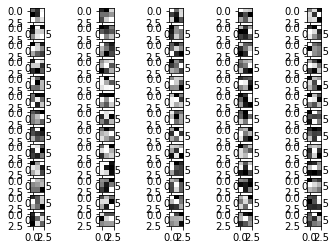

[[ 0.04483011 -0.03294126 -0.2520436 ]
 [-0.136952   -0.0332871  -0.291974  ]
 [ 0.10231801  0.01057275 -0.22145674]]
[[ 0.25449643 -0.20428678  0.16576833]
 [ 0.01092878  0.03091703  0.19665118]
 [ 0.0851338  -0.12557334  0.20502642]]
[[ 0.2693378   0.15695387 -0.06902978]
 [-0.05960359  0.28360027 -0.01345756]
 [-0.2736119   0.03581434 -0.1807249 ]]
[[ 0.13720453 -0.2737638   0.12167785]
 [ 0.14045615  0.33753893 -0.01182011]
 [-0.13094455 -0.05111141  0.1037202 ]]
[[-0.15905252  0.00045647  0.04897775]
 [ 0.34343842 -0.3418489   0.15791063]
 [-0.04418298 -0.22852035 -0.19719198]]


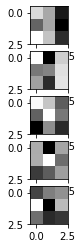

In [42]:
plot_weights(model)